In [1]:
import logging
logging.basicConfig(filename='vae.log', level=logging.INFO)

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/dryrun/'

In [3]:
col_name = 'HR'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [4]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [5]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [94]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


## Create Actions


In [95]:
nra = 5
nr_reps = 2

In [96]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [97]:
len(MIMICtable)

30885

In [98]:
MIMICtable['A'] = actionbloc['action_bloc']

In [102]:
a_columns = ['A']
x_columns = ['gender', 'age', 'Weight_kg', 'paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']

In [103]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2].reset_index()
MIMICtable_filtered_t2 = MIMICtable[MIMICtable['bloc']==3].reset_index()
MIMICtable_filtered_t3 = MIMICtable[MIMICtable['bloc']==4].reset_index()
MIMICtable_filtered_t4 = MIMICtable[MIMICtable['bloc']==5].reset_index()

MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[x_columns[1:]].min(axis=1)>0].reset_index()

MIMICtable_filtered_t2 = MIMICtable_filtered_t2[MIMICtable_filtered_t2[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t3 = MIMICtable_filtered_t3[MIMICtable_filtered_t3[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t4 = MIMICtable_filtered_t4[MIMICtable_filtered_t4[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)

In [104]:
MIMIC_t0 = MIMICtable_filtered_t0[['icustay_id'] + x_columns + a_columns].copy()
MIMIC_t1 = MIMICtable_filtered_t1[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t2 = MIMICtable_filtered_t2[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t3 = MIMICtable_filtered_t3[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t4 = MIMICtable_filtered_t4[['icustay_id'] + x_columns[3:] + a_columns].copy()

mimic_t0_rename = {}
mimic_t1_rename = {}
mimic_t2_rename = {}
mimic_t3_rename = {}
mimic_t4_rename = {}

for col in (x_columns[3:] + a_columns):
    mimic_t0_rename.update({col: f"{col}_t0"})
    mimic_t1_rename.update({col: f"{col}_t1"})
    mimic_t2_rename.update({col: f"{col}_t2"})
    mimic_t3_rename.update({col: f"{col}_t3"})
    mimic_t4_rename.update({col: f"{col}_t4"})
    MIMIC_t0 = MIMIC_t0.rename(columns=mimic_t0_rename)
    MIMIC_t1 = MIMIC_t1.rename(columns=mimic_t1_rename)
    MIMIC_t2 = MIMIC_t2.rename(columns=mimic_t2_rename)
    MIMIC_t3 = MIMIC_t3.rename(columns=mimic_t3_rename)
    MIMIC_t4 = MIMIC_t4.rename(columns=mimic_t4_rename)

MIMIC_combined = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t2, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t3, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t4, on=['icustay_id'])

In [105]:
MIMIC_combined_raw = MIMIC_combined.copy()

for col in x_columns[3:]:
    MIMIC_combined_raw[f'{col}_t0'] = (MIMIC_combined[f'{col}_t0'] - MIMIC_combined[f'{col}_t0'].mean())/MIMIC_combined[f'{col}_t0'].std()
    MIMIC_combined_raw[f'{col}_t1'] = (MIMIC_combined[f'{col}_t1'] - MIMIC_combined[f'{col}_t1'].mean())/MIMIC_combined[f'{col}_t1'].std()
    MIMIC_combined_raw[f'{col}_t2'] = (MIMIC_combined[f'{col}_t2'] - MIMIC_combined[f'{col}_t2'].mean())/MIMIC_combined[f'{col}_t2'].std()
    MIMIC_combined_raw[f'{col}_t3'] = (MIMIC_combined[f'{col}_t3'] - MIMIC_combined[f'{col}_t3'].mean())/MIMIC_combined[f'{col}_t3'].std()
    MIMIC_combined_raw[f'{col}_t4'] = (MIMIC_combined[f'{col}_t4'] - MIMIC_combined[f'{col}_t4'].mean())/MIMIC_combined[f'{col}_t4'].std()


MIMIC_combined_raw['age'] = (MIMIC_combined['age']-MIMIC_combined['age'].mean())/MIMIC_combined['age'].std()
MIMIC_combined_raw['Weight_kg'] = (MIMIC_combined['Weight_kg']-MIMIC_combined['Weight_kg'].mean())/MIMIC_combined['Weight_kg'].std()

In [106]:
len(MIMIC_combined.columns)

84

In [317]:
gender = 1.0

In [318]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

latent_dim = 50
hidden_dim = 200
data_dim = 77
n_act = 25

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc11 = nn.Linear(data_dim, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc13 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc41 = nn.Linear(hidden_dim, hidden_dim)
        self.fc42 = nn.Linear(hidden_dim, hidden_dim)
        self.fc43 = nn.Linear(hidden_dim, data_dim)
        self.fc44 = nn.Linear(hidden_dim, data_dim)
        self.fc45 = nn.Linear(hidden_dim, int(data_dim*(data_dim-1)/2))
        self.fc46 = nn.Linear(latent_dim, n_act)

    def encode(self, x):
        h1 = torch.tanh(self.fc11(x))
        h1 = F.leaky_relu(self.fc12(h1))
        h1 = F.leaky_relu(self.fc13(h1))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        h3 = torch.tanh(self.fc41(h3))
        h3 = F.leaky_relu(self.fc42(h3))
        t = torch.tril_indices(row=data_dim-1, col=data_dim-1, offset=0)
        lower_tr = torch.zeros((z.shape[0], data_dim, data_dim))
        lower_tr[:, t[0]+1, t[1]] = self.fc45(h3)
        cov_mat = torch.multiply(lower_tr, lower_tr.transpose(1,2))
        diag_var = self.fc44(h3).exp()
        cov_mat[:, torch.arange(data_dim), torch.arange(data_dim)] = diag_var
        return self.fc43(h3), cov_mat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        dec_mu, dec_cov_mat = self.decode(z)
        return dec_mu, dec_cov_mat, mu, logvar

In [319]:
icuuniqueids = MIMIC_combined['icustay_id'].unique()

grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
                                    
train = torch.utils.data.TensorDataset(X)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = torch.utils.data.TensorDataset(Xtestmimic)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

In [320]:
def loss_function_deprecated(recon_x, logvar_lik, x, mu, logvar):
#     BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
#     mse_loss = F.mse_loss(torch.div(recon_x, ), x, reduction='sum')
    mse_loss = torch.sum(torch.square(recon_x - x)/2/torch.exp(logvar_lik) + 0.5*logvar_lik)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + KLD

In [321]:
def loss_function(dec_mu, dec_covmat, x, mu, logvar):
    nlog_lik = (0.5*((dec_mu - x).unsqueeze(dim=1) @ dec_covmat.inverse() @ (dec_mu - x).unsqueeze(dim=2)).squeeze() + 0.5*dec_covmat.logdet()).sum()

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return nlog_lik + KLD

In [322]:
device = 'cpu'
model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0, betas=(0.99,0.999), amsgrad=True)
# optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.1, centered=True, momentum=0.9) -- seems fairly good
optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.0, centered=True, momentum=0.9)
test_losses = []
train_loss = 0

In [323]:
epochs = 400
for epoch in tqdm(range(epochs), position=0, leave=True):
    for data, in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        dec_mu, dec_cov_mat, mu, logvar = model(data)
        loss = loss_function(dec_mu, dec_cov_mat, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        test_loss = 0
        with torch.no_grad():
            for testdata, in testloader:
                testdata = testdata.to(device)
                recon_batch, logvar_lik, mu, logvar = model(testdata)
                test_loss += loss_function(recon_batch, logvar_lik, testdata, mu, logvar).item()
            test_losses.append(test_loss/len(testloader.dataset))

100%|██████████| 400/400 [06:11<00:00,  1.08it/s]


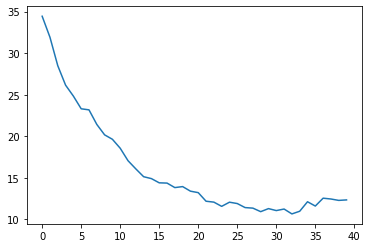

In [324]:
plt.plot(test_losses)

In [325]:
from torch.distributions.multivariate_normal import MultivariateNormal

def sample_multivariate(mu, cov):
    m = MultivariateNormal(mu, covariance_matrix=cov)
    return m.sample()

In [326]:
with torch.no_grad():
    sample = torch.randn(20000, latent_dim).to(device)
    mu, cov = model.decode(sample)
    sample = sample_multivariate(mu, cov)
print(sample)

tensor([[-0.5453,  0.3576,  2.7738,  ...,  0.7794, -1.1947,  0.2436],
        [ 2.2482, -0.9244,  0.2814,  ..., -2.1290,  0.9300, -1.6548],
        [ 0.6551, -0.9907, -0.1217,  ..., -0.5286, -0.7319,  0.3684],
        ...,
        [-0.7253,  0.0558, -0.8772,  ...,  0.5444, -0.1446,  1.4401],
        [-0.1182, -0.1922,  1.2970,  ..., -0.5433, -1.0646, -0.9537],
        [-0.1088, -0.4250, -0.0782,  ...,  0.4577,  0.2818, -1.1482]])


In [327]:
sample.shape
MIMIC_filtered = MIMIC_combined.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4'])
resampled = pd.DataFrame(data=sample.numpy(), columns=MIMIC_filtered.columns)*MIMIC_filtered.std() + MIMIC_filtered.mean()
resampled

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t4,DiaBP_t4,Glucose_t4,MeanBP_t4,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4
0,20627.046780,90.977514,77.120907,134.211189,1685.390437,7.155048,89.522506,3174.714062,41.614463,3923.868658,...,3809.703226,53.336164,1908.993504,71.590709,118.990022,16.728269,36.698834,3268.183177,94.935442,90.302002
1,37304.679983,59.572566,46.560879,78.740168,1380.632611,7.463148,105.841333,3863.429803,56.102083,3529.099469,...,3420.019074,42.498303,1667.616807,67.445118,187.313686,20.565053,37.343521,2902.731198,139.816967,56.990174
2,27793.474528,57.950668,41.618773,504.179248,1359.479611,7.365119,76.799253,3836.238998,81.659249,1232.636764,...,3869.963363,68.044789,1572.059504,64.324427,145.009789,23.101121,36.308459,3103.826606,104.711474,92.491305
3,23427.340101,101.184687,40.111278,458.382185,1070.081022,7.458320,81.769764,3663.195426,45.218374,1361.333919,...,3836.416996,33.866807,1631.497093,63.790026,156.246633,18.295914,37.775728,3094.680114,100.825952,83.046815
4,21105.368765,56.261944,51.128507,221.341858,1828.805152,7.382595,93.078954,3503.444817,51.702851,1923.034219,...,3551.167714,54.694700,1586.478062,67.549909,159.009195,17.241718,35.814674,3191.382913,110.970685,77.058183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,35094.142651,61.416651,46.617742,183.606712,1289.707399,7.374653,73.834354,3859.561814,73.632293,1469.612966,...,3995.261684,59.309137,1333.195473,75.328333,149.855829,22.949863,36.510876,3263.419329,106.811699,101.339044
19996,28376.535740,76.820185,47.148341,127.121836,1205.833183,7.413353,89.085738,3744.953897,26.162568,1095.668878,...,3721.288877,35.279087,1134.771974,66.564370,165.154275,18.158548,35.987734,3066.417945,136.961307,70.034179
19997,19552.486110,83.583448,32.355020,213.653178,1701.440958,7.468846,79.496479,3705.826473,70.020131,405.252670,...,3557.264076,58.389225,860.972887,75.668032,185.951053,22.931185,36.827724,3238.663634,117.118355,111.297399
19998,23176.672684,77.509588,59.013770,189.253626,1795.395507,7.398816,88.140487,3310.371997,56.594401,1274.517023,...,3406.137037,65.208082,1120.345850,91.317307,103.162585,7.384811,36.824428,3101.988347,97.682879,69.291765


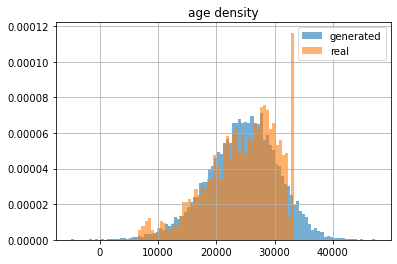

In [328]:
col_name = 'age'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

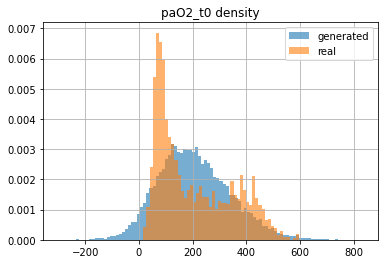

In [329]:
col_name = 'paO2_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

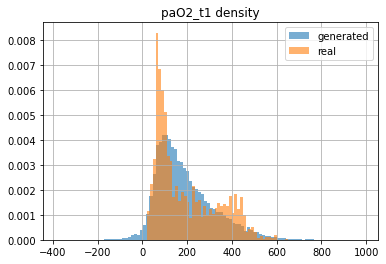

In [330]:
col_name = 'paO2_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

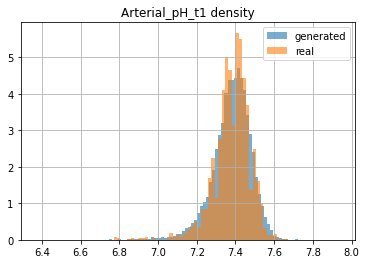

In [331]:
col_name = 'Arterial_pH_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

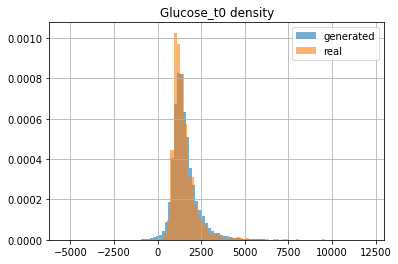

In [332]:
col_name = 'Glucose_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

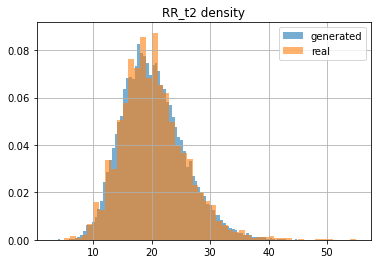

In [333]:
col_name = 'RR_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

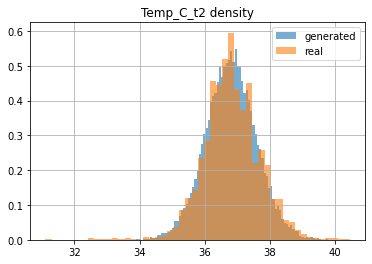

In [334]:
col_name = 'Temp_C_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

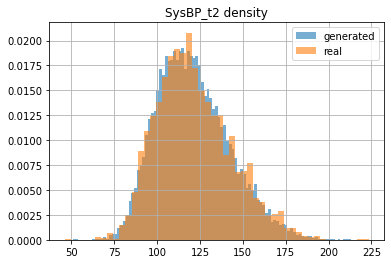

In [335]:
col_name = 'SysBP_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

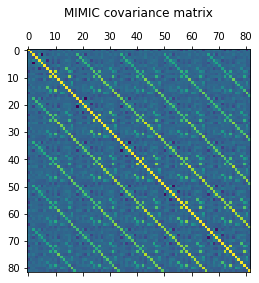

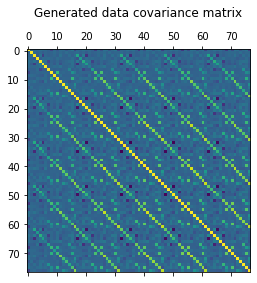

In [336]:
import matplotlib.pyplot as plt

plt.matshow(MIMIC_combined_raw[MIMIC_combined['gender']==gender].drop(columns=['icustay_id', 'gender']).corr())
plt.title('MIMIC covariance matrix\n')
plt.matshow(resampled.corr())
plt.title('Generated data covariance matrix\n')
plt.show()

# Predicting actions $a_0$ using $x_0$

In [337]:
Y = MIMIC_t0['A_t0']-1
MIMIC_t0_raw = MIMIC_t0.copy().drop(columns=['icustay_id', 'gender', 'A_t0'])
MIMIC_t0_raw = (MIMIC_t0_raw - MIMIC_t0_raw.mean())/MIMIC_t0_raw.std()

MIMIC_t0_raw

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,MeanBP_t0,Potassium_t0,RR_t0,Temp_C_t0,Sodium_t0,SysBP_t0,HR_t0
0,-0.180865,1.009550,-0.252815,-0.530215,-1.195648,-0.302869,0.672453,-2.281678,-0.057249,-0.388401,0.059557,1.094357,-1.135895,-0.793011,-0.338612,-0.496443,-0.582805
1,-1.045358,-0.650561,0.236240,0.243913,1.296502,-0.837704,-0.528679,-0.687089,0.414806,-0.590386,0.225010,-6.610666,0.685326,0.442992,-1.879331,-0.116606,-0.417558
2,0.020369,-0.340565,0.073221,1.472574,0.721391,0.124998,-2.030093,0.110206,-0.697895,-0.280676,-0.635346,0.131229,0.958509,0.187268,0.046567,-0.429413,-0.004442
3,0.010258,-1.551996,-1.801488,-0.807197,-1.003944,2.157368,0.071887,-0.288441,1.594943,1.826698,1.350092,1.415399,1.595936,-0.409423,-0.916382,-0.004890,1.317532
4,1.184268,-0.365038,0.725294,0.179994,-0.045425,-1.372538,-0.828962,1.385878,0.347370,-0.455729,0.066912,0.131229,-1.742969,0.102025,1.202106,-0.347488,-0.711330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6172,-0.101932,-1.723310,-0.089797,-1.069974,1.104798,1.301633,-0.528679,-1.324925,1.201564,-0.630783,1.537606,-0.671378,0.563911,-0.665148,0.046567,1.946430,0.573922
6173,-1.648365,0.071404,-0.089797,-0.878218,0.721391,0.659832,-0.528679,0.110206,-1.147471,-0.576920,-0.800799,-0.075156,1.049570,-0.196320,-0.146022,0.144066,-1.298874
6174,-0.038579,0.724027,0.073221,1.934210,-1.003944,0.231965,-0.628773,1.066960,-0.394431,-0.859699,-0.116928,-0.751638,-1.500139,-0.452044,0.624337,0.263231,-2.180189
6175,1.592570,-0.874900,0.154731,-0.878218,-0.812240,0.124998,0.071887,-1.006007,0.381088,-0.361470,0.158829,0.131229,-0.407407,0.954441,-1.686741,-0.205980,0.261789


In [338]:
from sklearn.linear_model import LogisticRegression
icuuniqueids = MIMIC_t0.loc[MIMIC_t0['gender']==gender, 'icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')
model_n = 0
logging.info('Model: ' + str(model_n))
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = MIMIC_t0_raw.loc[(MIMIC_t0['gender']==gender) & MIMIC_t0['icustay_id'].isin(trainidx)]
Xtestmimic = MIMIC_t0_raw[(MIMIC_t0['gender']==gender) & (MIMIC_t0['icustay_id'].isin(testidx))]
Y = MIMIC_t0.loc[(MIMIC_t0['gender']==gender) & MIMIC_t0['icustay_id'].isin(trainidx), 'A_t0']-1
Ytest = MIMIC_t0.loc[(MIMIC_t0['gender']==gender) & (MIMIC_t0['icustay_id'].isin(testidx)), 'A_t0']-1

clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
acc_train = clf.score(X, Y)
acc_test = clf.score(Xtestmimic, Ytest)
modelsDf = modelsDf.append({'model': model_n, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

In [339]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.499099,0.52362,0.0,"LogisticRegression(C=1.0, class_weight=None, d..."


In [138]:
from torch.distributions.categorical import Categorical

x_columns_t0 = x_columns[1:3]
for col in x_columns[3:]:
    x_columns_t0.append(f'{col}_t0')

sampled_t0 = pd.DataFrame(data=sample.numpy(), columns=MIMIC_filtered.columns)[x_columns_t0]
sampled_t0.head()
probs = torch.tensor(clf.predict_proba(sampled_t0))
m = Categorical(probs)
resampled['A_t0'] = (m.sample()+1).numpy()

# Using NN to model $\pi(a_0\mid x_0)$

In [340]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [341]:
X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx)), 'A_t0'].values-1).to(torch.long)

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1], output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [342]:
MIMIC_combined_raw.head()

,icustay_id,gender,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,...,DiaBP_t4,Glucose_t4,MeanBP_t4,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4,A_t4
0,65537,0.0,-0.181437,1.011728,-0.253698,-0.529900,-1.196704,-0.304539,0.686031,-2.280015,...,-0.146002,-0.429286,-0.195226,1.843792,0.863103,0.244385,-0.347336,-0.670883,-0.044281,2
1,65544,0.0,0.019738,-0.339540,0.072532,1.472536,0.719424,0.123432,-2.104195,0.110587,...,2.212792,-0.063226,2.172761,-0.010115,0.772564,-1.167796,0.201545,1.459343,1.252217,3
2,98314,0.0,0.009631,-1.552008,-1.803290,-0.806833,-1.005091,2.156296,0.065981,-0.287847,...,0.859954,3.288257,0.492802,3.697699,1.225259,4.103249,-0.713257,-0.670883,0.349893,6
3,14,0.0,1.183295,-0.364035,0.724992,0.180184,-0.047027,-1.374468,-0.864094,1.385575,...,0.385882,-0.681461,-0.395901,0.158422,-1.822885,0.211543,1.116346,0.228546,-0.951354,7
4,65553,0.0,-0.760902,-0.498753,0.154089,-1.154774,3.018777,1.728325,-0.140703,-2.280015,...,-0.964643,0.782779,-1.345379,0.326959,-0.676059,-0.379604,-0.530297,-1.466167,0.044052,2


In [343]:
for epoch in tqdm(range(1000)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 1000/1000 [00:26<00:00, 37.30it/s]


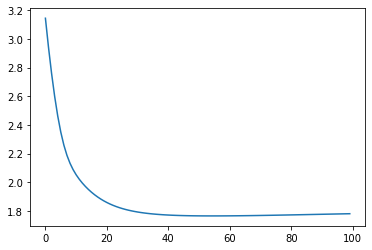

In [344]:
plt.plot(losses)

In [345]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtestmimic)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 48 %


In [346]:
from torch.distributions.categorical import Categorical

probs = policy(sample)
m = Categorical(logits=probs)
resampled['A_t0'] = (m.sample()+1).numpy()

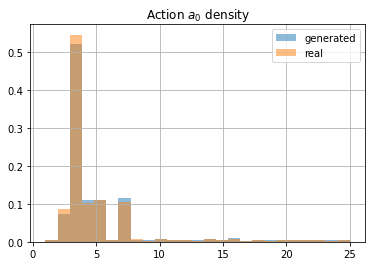

In [347]:
resampled['A_t0'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t0['A_t0'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_0$ density')
plt.show()

# Predicting actions $a_1$ using $x_0,a_0,x_1$

In [348]:
MIMIC_t1.head()

,icustay_id,paCO2_t1,paO2_t1,HCO3_t1,Arterial_pH_t1,Calcium_t1,Chloride_t1,DiaBP_t1,Glucose_t1,MeanBP_t1,Potassium_t1,RR_t1,Temp_C_t1,Sodium_t1,SysBP_t1,HR_t1,A_t1
0,65537,33.0,155.0,1769.4872,7.31,84.0,3651.35,63.0,1560.0,79.000000,173.335797,18.833333,35.833333,3126.608584,117.0,70.500000,2
1,65544,39.0,351.0,1342.3696,7.42,84.0,3686.80,41.5,1565.0,64.000000,232.634885,15.000000,37.444445,3172.588122,109.0,80.000000,3
2,98314,36.0,385.0,1159.3192,7.40,86.0,3651.35,88.0,2840.0,105.500000,187.671840,29.000000,36.444446,2988.669970,128.0,111.500000,3
3,14,31.0,179.0,1464.4032,7.45,77.0,3970.40,57.5,1125.0,76.666701,164.212860,10.000000,37.000000,3310.526736,115.0,65.666667,2
4,65553,85.0,36.0,1586.4368,7.33,102.0,3509.55,61.0,1100.0,76.500000,179.852180,21.000000,36.777776,3057.639277,107.5,79.000000,2


In [349]:
MIMIC_t0_t1 = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
a0 = MIMIC_t0_t1.loc[MIMIC_t0_t1['gender']==gender, 'A_t0']-1
a1 = MIMIC_t0_t1.loc[MIMIC_t0_t1['gender']==gender, 'A_t1']-1

MIMIC_t0_t1_raw = MIMIC_t0_t1.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1'])
MIMIC_t0_t1_raw = (MIMIC_t0_t1_raw - MIMIC_t0_t1_raw.mean())/MIMIC_t0_t1_raw.std()
MIMIC_t0_t1_raw.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t1,DiaBP_t1,Glucose_t1,MeanBP_t1,Potassium_t1,RR_t1,Temp_C_t1,Sodium_t1,SysBP_t1,HR_t1
0,-0.181651,1.009558,-0.253319,-0.530349,-1.195552,-0.302556,0.685612,-2.282265,-0.059114,-0.388517,...,-0.044585,0.332645,0.124296,-0.029747,0.409038,-0.255311,-0.332732,-0.337391,-0.243898,-0.929564
1,0.019470,-0.341619,0.073037,1.471981,0.721420,0.125050,-2.090557,0.110156,-0.700561,-0.280904,...,0.110101,-1.147722,0.131502,-1.028884,2.715350,-0.951461,0.166105,0.034928,-0.608895,-0.410179
2,0.009365,-1.554004,-1.803509,-0.807267,-1.003855,2.156179,0.068686,-0.288581,1.595144,1.824270,...,-0.044585,2.054002,1.968964,1.735395,0.966608,1.591000,-0.143518,-1.454348,0.257973,1.311990
3,1.182713,-0.366111,0.725749,0.179697,-0.045369,-1.371572,-0.856704,1.386113,0.346010,-0.455775,...,1.347591,-0.046053,-0.502603,-0.185166,0.054221,-1.859483,0.028494,1.151884,-0.335147,-1.193812
4,-0.760960,-0.500821,0.154626,-1.155190,3.021786,1.728573,-0.136957,-2.282265,-0.092875,-0.469226,...,-0.663330,0.194937,-0.538631,-0.196270,0.662479,0.138165,-0.040311,-0.895869,-0.677332,-0.464851


In [350]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 1, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [358]:
for epoch in tqdm(range(1500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:13<00:00, 37.75it/s]


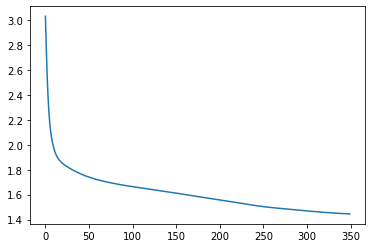

In [359]:
plt.plot(losses)

In [360]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 61 %


In [361]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
probs = policy(torch.column_stack((sample, a0)))
m = Categorical(logits=probs)
resampled['A_t1'] = (m.sample()+1).numpy()

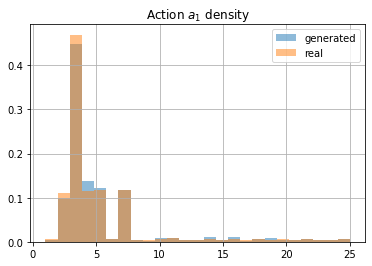

In [362]:
resampled['A_t1'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t1['A_t1'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_1$ density')
plt.show()

# Predicting actions $a_2$ using $x_0,a_0,x_1, a_1, x_2$

In [363]:
MIMIC_t0_t1_t2 = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
MIMIC_t0_t1_t2 = MIMIC_t0_t1_t2.merge(MIMIC_t2, on=['icustay_id'])

a0 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t0']-1
a1 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t1']-1
a2 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t2']-1

MIMIC_t0_t1_t2_raw = MIMIC_t0_t1_t2.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2'])
MIMIC_t0_t1_t2_raw = (MIMIC_t0_t1_t2_raw - MIMIC_t0_t1_t2_raw.mean())/MIMIC_t0_t1_t2_raw.std()
MIMIC_t0_t1_t2_raw.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t2,DiaBP_t2,Glucose_t2,MeanBP_t2,Potassium_t2,RR_t2,Temp_C_t2,Sodium_t2,SysBP_t2,HR_t2
0,-0.181283,1.010671,-0.252843,-0.530910,-1.195216,-0.302845,0.687440,-2.280472,-0.059935,-0.388697,...,-0.501525,-0.889362,-0.307961,-0.986493,-0.686014,0.649171,-1.106747,-0.323616,-0.844195,-0.534832
1,0.019864,-0.340915,0.073515,1.472477,0.720882,0.124818,-2.104938,0.110574,-0.701253,-0.281147,...,0.711443,0.224971,0.534780,-0.156856,0.653969,0.168724,-0.088084,-0.685817,-0.637016,-0.447512
2,0.009758,-1.553668,-1.803041,-0.807974,-1.003606,2.156218,0.066912,-0.287934,1.593990,1.822801,...,-0.046662,2.105406,1.920302,1.799199,0.958510,1.647021,-0.447610,-1.410219,0.306799,1.326180
3,1.183264,-0.365415,0.726230,0.179511,-0.045557,-1.372003,-0.863881,1.385798,0.345108,-0.455916,...,1.317927,0.364262,-0.636486,0.652546,0.044886,-1.771541,0.151603,1.125189,0.444919,-1.566302
4,-0.760671,-0.500166,0.155104,-1.156081,3.020199,1.728554,-0.139931,-2.280472,-0.093689,-0.469359,...,0.256580,-0.018790,0.649050,-0.280516,0.501698,-0.016063,-0.088084,0.762988,-0.567956,-0.283787


In [364]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

A1 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
A1test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t2'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t2'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0, A1)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test, A1test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 2, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [377]:
for epoch in tqdm(range(1500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:12<00:00, 39.12it/s]


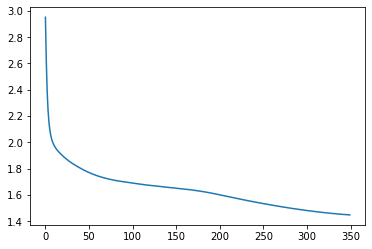

In [378]:
plt.plot(losses)

In [379]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test, A1test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 59 %


In [380]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
a1 = torch.tensor(resampled['A_t1'].values).to(torch.long)-1
# sampled_t0.head()
probs = policy(torch.column_stack((sample, a0, a1)))
m = Categorical(logits=probs)
resampled['A_t2'] = (m.sample()+1).numpy()

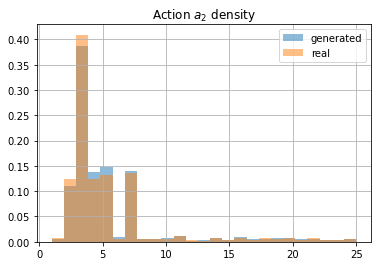

In [381]:
resampled['A_t2'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t2['A_t2'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_2$ density')
plt.show()

# Predicting actions $a_3$ using $x_0,a_0,x_1, a_1, x_2, a_2, x_3$

In [382]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

A1 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
A1test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

A2 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t2'].values-1).to(torch.long)
A2test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t2'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t3'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t3'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0, A1, A2)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test, A1test, A2test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 3, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [389]:
for epoch in tqdm(range(1500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:12<00:00, 38.62it/s]


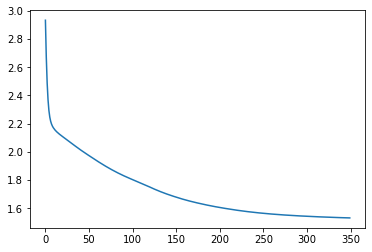

In [390]:
plt.plot(losses)

In [392]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test, A1test, A2test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 55 %


In [393]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
a1 = torch.tensor(resampled['A_t1'].values).to(torch.long)-1
a2 = torch.tensor(resampled['A_t2'].values).to(torch.long)-1
# sampled_t0.head()
probs = policy(torch.column_stack((sample, a0, a1, a2)))
m = Categorical(logits=probs)
resampled['A_t3'] = (m.sample()+1).numpy()

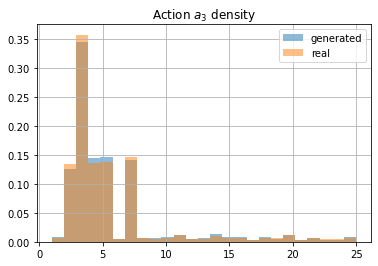

In [394]:
resampled['A_t3'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t3['A_t3'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_3$ density')
plt.show()

In [395]:
resampled.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4,A_t0,A_t1,A_t2,A_t3
0,20627.046780,90.977514,77.120907,134.211189,1685.390437,7.155048,89.522506,3174.714062,41.614463,3923.868658,...,118.990022,16.728269,36.698834,3268.183177,94.935442,90.302002,4,14,7,5
1,37304.679983,59.572566,46.560879,78.740168,1380.632611,7.463148,105.841333,3863.429803,56.102083,3529.099469,...,187.313686,20.565053,37.343521,2902.731198,139.816967,56.990174,6,7,7,7
2,27793.474528,57.950668,41.618773,504.179248,1359.479611,7.365119,76.799253,3836.238998,81.659249,1232.636764,...,145.009789,23.101121,36.308459,3103.826606,104.711474,92.491305,3,3,3,4
3,23427.340101,101.184687,40.111278,458.382185,1070.081022,7.458320,81.769764,3663.195426,45.218374,1361.333919,...,156.246633,18.295914,37.775728,3094.680114,100.825952,83.046815,3,3,3,3
4,21105.368765,56.261944,51.128507,221.341858,1828.805152,7.382595,93.078954,3503.444817,51.702851,1923.034219,...,159.009195,17.241718,35.814674,3191.382913,110.970685,77.058183,1,2,2,3


# Visualising trajectories

MIMIC datapoints: 1.0%
Generated datapoints: 0.03%


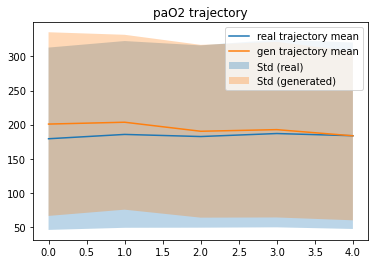

In [403]:
col_name = "paO2"
At = [3,3,3,4]

col_v = []
col_v_ub = []
col_v_lb = []
col_v_real = []
col_v_ub_real = []
col_v_lb_real = []

resampled_filtered = resampled.copy()
MIMIC_combined_filtered = MIMIC_combined[MIMIC_combined['gender']==gender].copy()

for t in range(len(At)):
    resampled_filtered = resampled_filtered[resampled_filtered[f'A_t{t}']==At[t]]
    MIMIC_combined_filtered = MIMIC_combined_filtered[MIMIC_combined_filtered[f'A_t{t}']==At[t]]
    
print(f'MIMIC datapoints: {round(len(MIMIC_combined_filtered)/len(MIMIC_combined)*100,2)}%')
print(f'Generated datapoints: {round(len(resampled_filtered)/len(resampled),2)}%')


for t in range(5):
    col_v_lb.append(resampled_filtered[f'{col_name}_t{t}'].mean() - resampled_filtered[f'{col_name}_t{t}'].std())
    col_v_ub.append(resampled_filtered[f'{col_name}_t{t}'].mean() + resampled_filtered[f'{col_name}_t{t}'].std())
    col_v.append(resampled_filtered[f'{col_name}_t{t}'].mean())
    col_v_lb_real.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean() - MIMIC_combined_filtered[f'{col_name}_t{t}'].std())
    col_v_ub_real.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean() + MIMIC_combined_filtered[f'{col_name}_t{t}'].std())
    col_v_real.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean())
    
plt.plot(col_v_real, label='real trajectory mean')
plt.plot(col_v, label='gen trajectory mean')
plt.fill_between(list(range(5)), col_v_lb_real, col_v_ub_real, alpha=0.3, label='Std (real)')
plt.fill_between(list(range(5)), col_v_lb, col_v_ub, alpha=0.3, label='Std (generated)')
plt.title(f'{col_name} trajectory')
plt.legend()
plt.show()

In [404]:
resampled_f = resampled[(resampled.min(axis=1)>0) & (resampled['age'].between(18*365, 90*365))].copy()
resampled_f.loc[:,'gender'] = gender
resampled_f.loc[:,'icustay_id'] = np.array(range(len(resampled_f))) + 100000 + 100000*gender
resampled_f.loc[:,'A_t4'] = np.nan
resampled_t0 = resampled_f.loc[:,['icustay_id', 'gender', 'age', 'Weight_kg'] + list(mimic_t0_rename.values())].rename(columns={v: k for k, v in mimic_t0_rename.items()})
resampled_t0.loc[:, 'bloc'] = 1
resampled_t1 = resampled_f.loc[:,['icustay_id', 'gender', 'age', 'Weight_kg'] + list(mimic_t1_rename.values())].rename(columns={v: k for k, v in mimic_t1_rename.items()})
resampled_t1.loc[:, 'bloc'] = 2
resampled_t2 = resampled_f.loc[:,['icustay_id', 'gender', 'age', 'Weight_kg'] + list(mimic_t2_rename.values())].rename(columns={v: k for k, v in mimic_t2_rename.items()})
resampled_t2.loc[:, 'bloc'] = 3
resampled_t3 = resampled_f.loc[:,['icustay_id', 'gender', 'age', 'Weight_kg'] + list(mimic_t3_rename.values())].rename(columns={v: k for k, v in mimic_t3_rename.items()})
resampled_t3.loc[:, 'bloc'] = 4
resampled_t4 = resampled_f.loc[:,['icustay_id', 'gender', 'age', 'Weight_kg'] + list(mimic_t4_rename.values())].rename(columns={v: k for k, v in mimic_t4_rename.items()})
resampled_t4.loc[:, 'bloc'] = 5
generated_df = pd.concat([resampled_t0, resampled_t1, resampled_t2, resampled_t3, resampled_t4], ignore_index=True).sort_values(by=['icustay_id', 'bloc'], ignore_index=True)

In [405]:
generated_df.head()

,icustay_id,gender,age,Weight_kg,paCO2,paO2,HCO3,Arterial_pH,Calcium,Chloride,...,Glucose,MeanBP,Potassium,RR,Temp_C,Sodium,SysBP,HR,A,bloc
0,200000.0,1.0,27793.474528,57.950668,41.618773,504.179248,1359.479611,7.365119,76.799253,3836.238998,...,1232.636764,86.105972,142.018399,19.901024,36.666187,3164.036334,144.690478,82.795462,3.0,1
1,200000.0,1.0,27793.474528,57.950668,50.881904,315.638488,1380.508207,7.358558,74.711536,3644.189084,...,1613.009788,60.830804,159.040106,24.937723,36.708014,3182.510600,96.848719,53.917506,3.0,2
2,200000.0,1.0,27793.474528,57.950668,51.705944,270.938271,1501.608882,7.322744,77.282243,3764.494396,...,1328.098737,62.172179,171.512971,23.770281,36.968750,3147.198877,131.902567,57.105217,3.0,3
3,200000.0,1.0,27793.474528,57.950668,55.275465,419.709834,1160.824904,7.301700,68.843534,3777.403590,...,1361.114744,74.478228,142.866439,28.210467,36.476856,3105.488040,108.259521,86.199777,4.0,4
4,200000.0,1.0,27793.474528,57.950668,48.074850,474.985435,1318.222198,7.253942,90.576945,3869.963363,...,1572.059504,64.324427,145.009789,23.101121,36.308459,3103.826606,104.711474,92.491305,NaN,5


In [406]:
# generated_df.to_csv(f"/data/localhost/taufiq/export-dir/MIMIC-generated-length-5-gender-{gender}.csv")

In [424]:
# MIMICtable.head()

In [425]:
# MIMICfiltered = MIMICtable[(MIMICtable[x_columns[1:]].min(axis=1) > 0)].copy()
# MIMICfiltered = MIMICfiltered.groupby(by='icustay_id').filter(lambda x: len(x) == 5)
# len(MIMICfiltered)/5

In [423]:
# MIMICfiltered.to_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-filtered.csv", index=False)